In [0]:
import torch
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None) 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style('whitegrid') 
import warnings
warnings.filterwarnings('ignore') 
import datetime
import json
import logging
import os
import shutil
from scipy import stats
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.utils.data
from torch.autograd import Variable
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import neighbors 
from sklearn.metrics import mean_squared_error 
from sklearn import preprocessing 
from sklearn.tree import DecisionTreeRegressor
from math import log
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

tcmalloc: large alloc 1073750016 bytes == 0x58524000 @  0x7efdf36a52a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
def Dec_scale(df):
    for x in df:
        p = df[x].astype("int").max()
        q = len(str(abs(p)))        
        df[x] = df[x]/(10**q) 

In [0]:
def change2categorical(df,names):
  for x in names:
    df[x]=df[x].astype('object')
  

In [0]:

def save_checkpoint(state, is_best, checkpoint,time):
    """Saves model and training parameters at checkpoint + 'last.pth.tar'. If is_best==True, also saves
    checkpoint + 'best.pth.tar'
    Args:
        state: (dict) contains model's state_dict, may contain other keys such as epoch, optimizer state_dict
        is_best: (bool) True if it is the best model seen till now
        checkpoint: (string) folder where parameters are to be saved
    """
    filepath = os.path.join(checkpoint,str(time)+ 'last.pth.tar')
    if not os.path.exists(checkpoint):
        print("Checkpoint Directory does not exist! Making directory {}".format(checkpoint))
        os.mkdir(checkpoint)
    else:
        print("Checkpoint Directory exists! ")
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(checkpoint,str(time)+ 'best.pth.tar'))


def load_checkpoint(checkpoint, model, optimizer=None):
    """Loads model parameters (state_dict) from file_path. If optimizer is provided, loads state_dict of
    optimizer assuming it is present in checkpoint.
    Args:
        checkpoint: (string) filename which needs to be loaded
        model: (torch.nn.Module) model for which the parameters are loaded
        optimizer: (torch.optim) optional: resume optimizer from checkpoint
    """
    if not os.path.exists(checkpoint):
        raise("File doesn't exist {}".format(checkpoint))
    checkpoint = torch.load(checkpoint)
    model.load_state_dict(checkpoint['state_dict'])

    if optimizer:
        optimizer.load_state_dict(checkpoint['optim_dict'])

    return checkpoint

In [0]:
df=pd.read_csv("./drive/My Drive/DataSet/kc_house_data.csv",parse_dates=['date']);
df=df.drop(['id'],axis=1)


In [0]:
df.shape

(21613, 20)

In [0]:
df.head(5)

date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0 2014-10-13  221900.0         3       1.00         1180      5650     1.0   
1 2014-12-09  538000.0         3       2.25         2570      7242     2.0   
2 2015-02-25  180000.0         2       1.00          770     10000     1.0   
3 2014-12-09  604000.0         4       3.00         1960      5000     1.0   
4 2015-02-18  510000.0         3       2.00         1680      8080     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        1180              0      1955   
1           0     0          3      7        2170            400      1951   
2           0     0          3      6         770              0      1933   
3           0     0          5      7        1050            910      1965   
4           0     0          3      8        1680              0      1987   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1          1991    98125  47.7210 -122.319           1690        7639  
2             0    98028  47.7379 -122.233           2720        8062  
3             0    98136  47.5208 -122.393           1360        5000  
4             0    98074  47.6168 -122.045           1800        7503

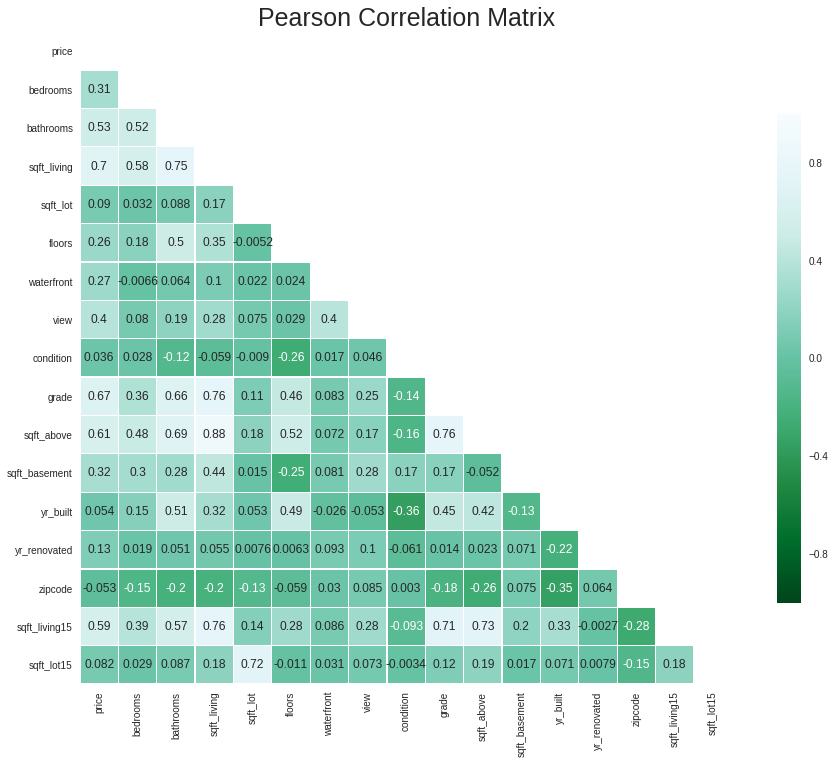

In [0]:
features = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors',
            'waterfront','view','condition','grade','sqft_above','sqft_basement',
            'yr_built','yr_renovated','zipcode','sqft_living15','sqft_lot15']

mask = np.zeros_like(df[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df[features].corr(),linewidths=0.25,vmax=1.0,square=True,cmap="BuGn_r", 
            linecolor='w',annot=True,mask=mask,cbar_kws={"shrink": .75})

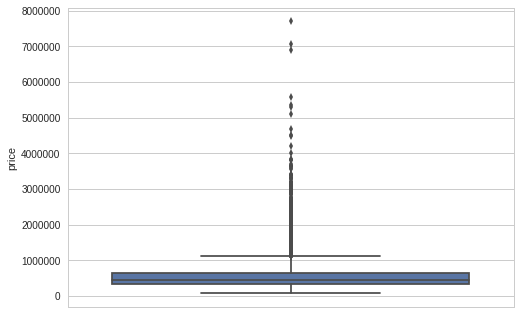

In [0]:
sns.boxplot(y=df["price"])
plt.show()

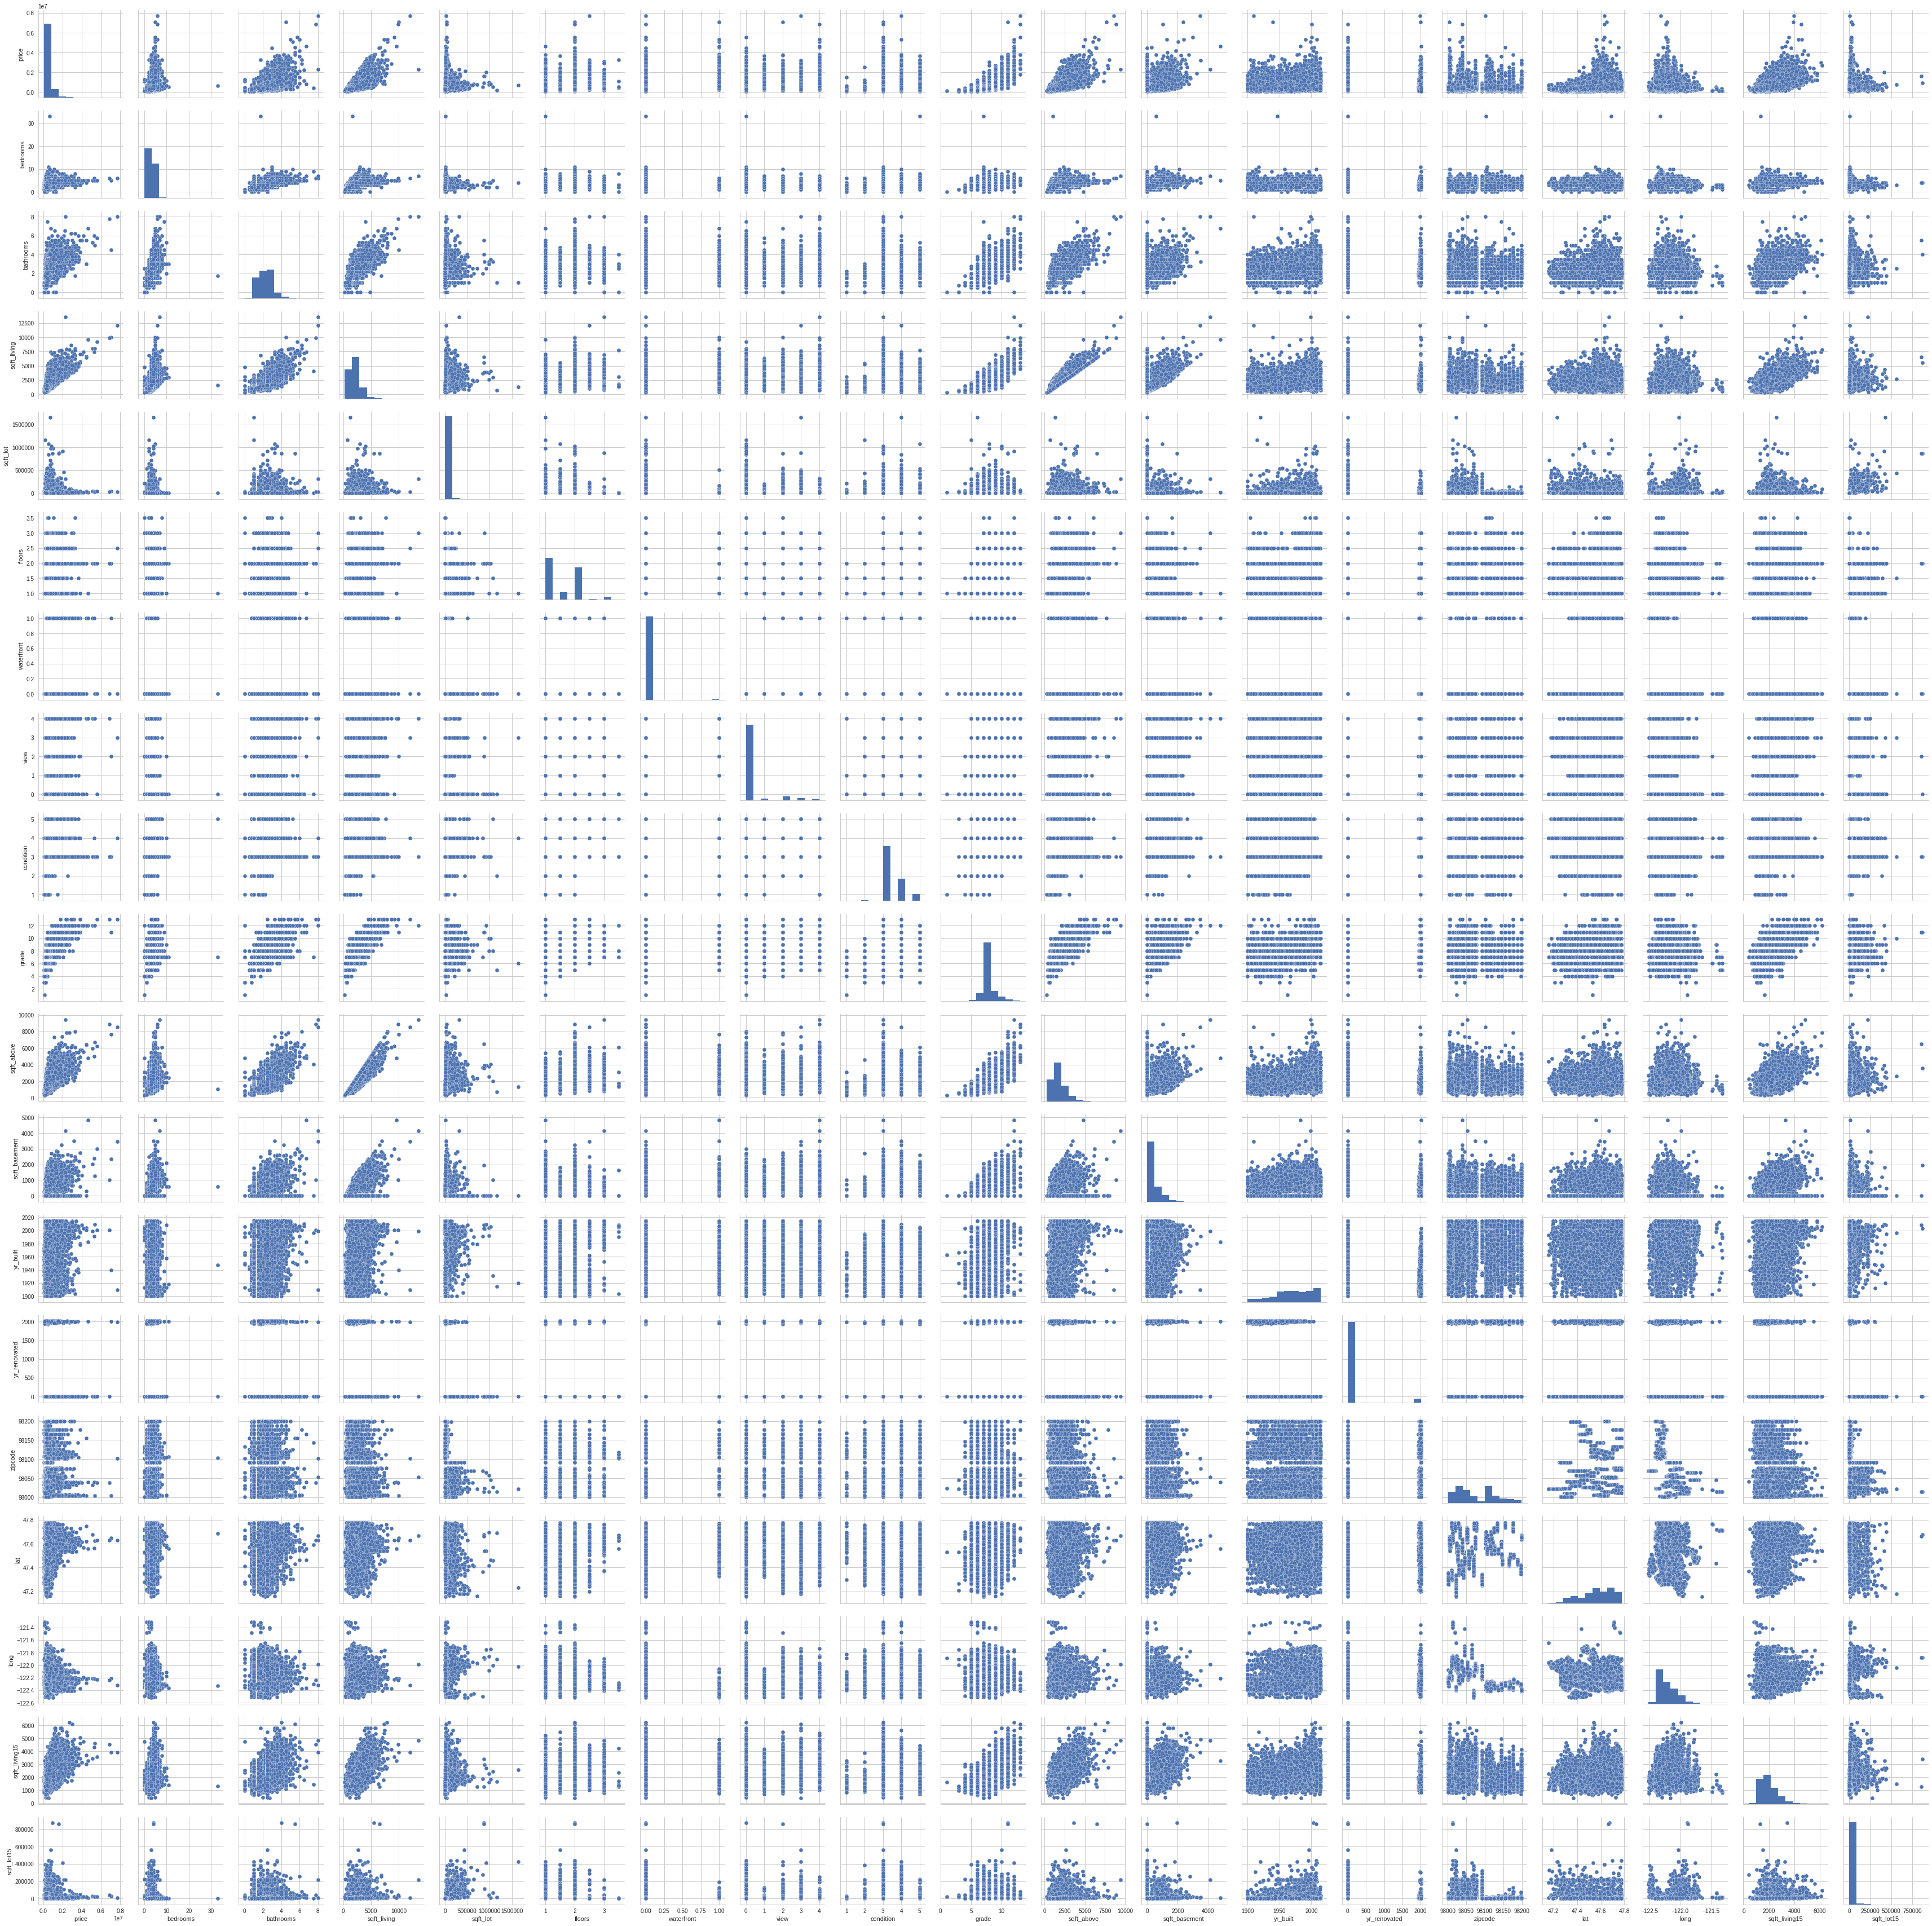

In [0]:
sns.pairplot(df)
plt.show()

In [0]:
df.describe()

price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count  2.161300e+04  21613.000000  21613.000000  21613.000000  2.161300e+04   
mean   5.400881e+05      3.370842      2.114757   2079.899736  1.510697e+04   
std    3.671272e+05      0.930062      0.770163    918.440897  4.142051e+04   
min    7.500000e+04      0.000000      0.000000    290.000000  5.200000e+02   
25%    3.219500e+05      3.000000      1.750000   1427.000000  5.040000e+03   
50%    4.500000e+05      3.000000      2.250000   1910.000000  7.618000e+03   
75%    6.450000e+05      4.000000      2.500000   2550.000000  1.068800e+04   
max    7.700000e+06     33.000000      8.000000  13540.000000  1.651359e+06   

             floors    waterfront          view     condition         grade  \
count  21613.000000  21613.000000  21613.000000  21613.000000  21613.000000   
mean       1.494309      0.007542      0.234303      3.409430      7.656873   
std        0.539989      0.086517      0.766318      0.650743      1.175459   
min        1.000000      0.000000      0.000000      1.000000      1.000000   
25%        1.000000      0.000000      0.000000      3.000000      7.000000   
50%        1.500000      0.000000      0.000000      3.000000      7.000000   
75%        2.000000      0.000000      0.000000      4.000000      8.000000   
max        3.500000      1.000000      4.000000      5.000000     13.000000   

         sqft_above  sqft_basement      yr_built  yr_renovated       zipcode  \
count  21613.000000   21613.000000  21613.000000  21613.000000  21613.000000   
mean    1788.390691     291.509045   1971.005136     84.402258  98077.939805   
std      828.090978     442.575043     29.373411    401.679240     53.505026   
min      290.000000       0.000000   1900.000000      0.000000  98001.000000   
25%     1190.000000       0.000000   1951.000000      0.000000  98033.000000   
50%     1560.000000       0.000000   1975.000000      0.000000  98065.000000   
75%     2210.000000     560.000000   1997.000000      0.000000  98118.000000   
max     9410.000000    4820.000000   2015.000000   2015.000000  98199.000000   

                lat          long  sqft_living15     sqft_lot15  
count  21613.000000  21613.000000   21613.000000   21613.000000  
mean      47.560053   -122.213896    1986.552492   12768.455652  
std        0.138564      0.140828     685.391304   27304.179631  
min       47.155900   -122.519000     399.000000     651.000000  
25%       47.471000   -122.328000    1490.000000    5100.000000  
50%       47.571800   -122.230000    1840.000000    7620.000000  
75%       47.678000   -122.125000    2360.000000   10083.000000  
max       47.777600   -121.315000    6210.000000  871200.000000

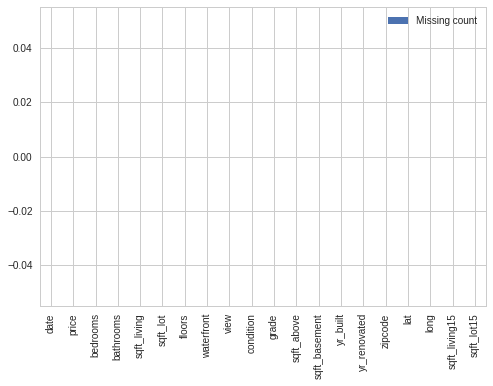

In [0]:
missing=pd.DataFrame({'Missing count':df.isnull().sum()})
missing.plot.bar()

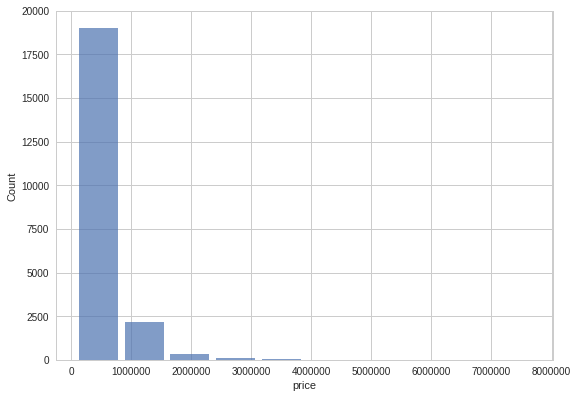

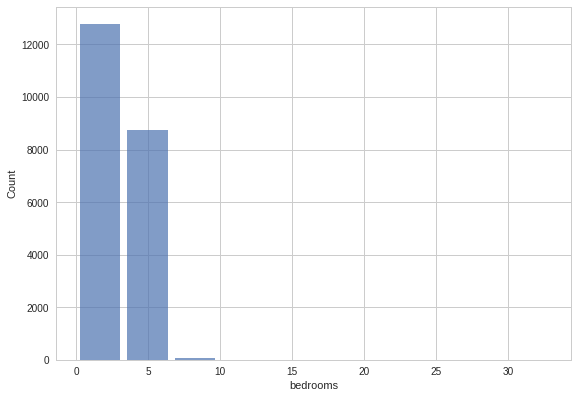

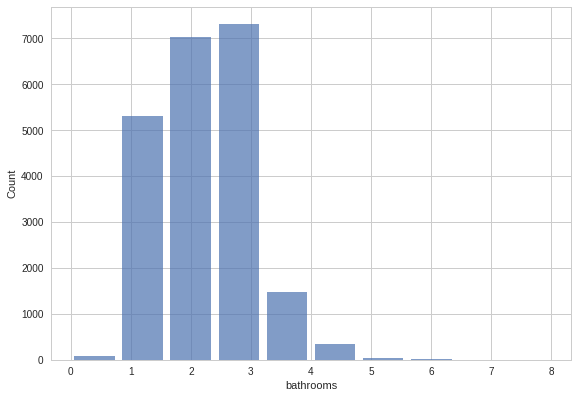

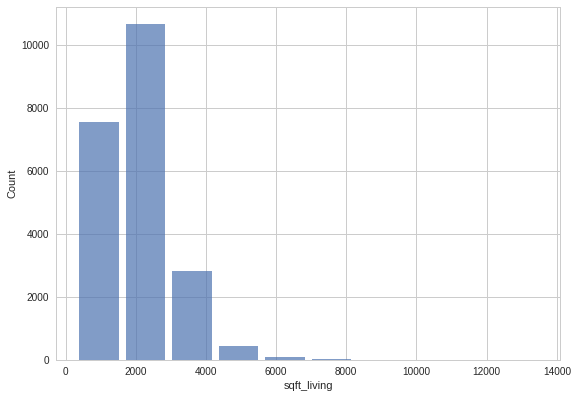

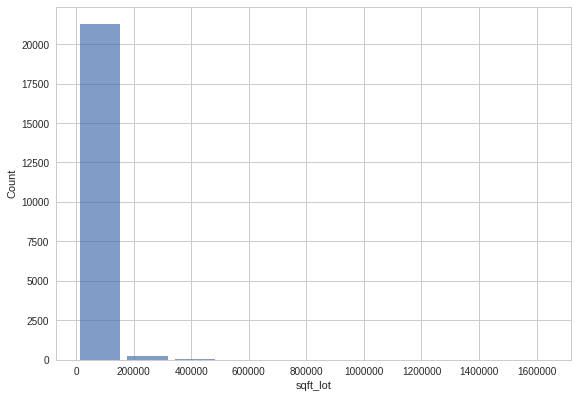

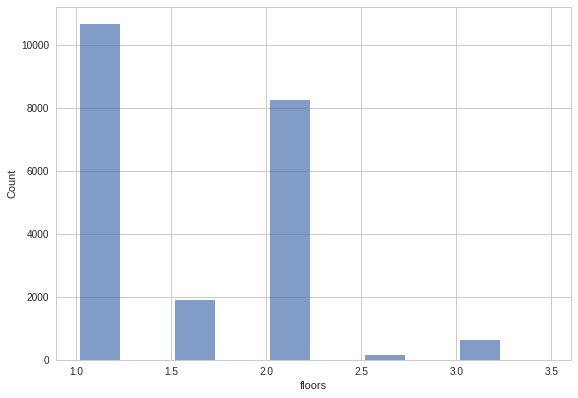

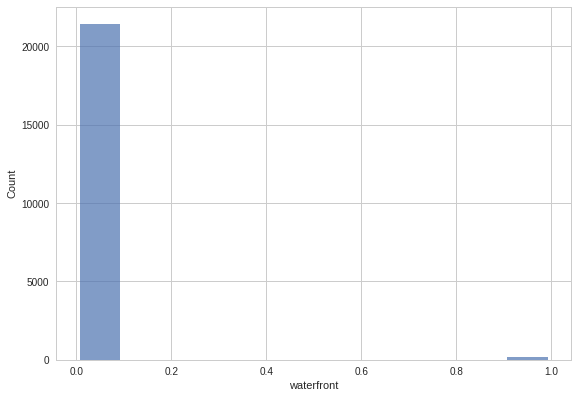

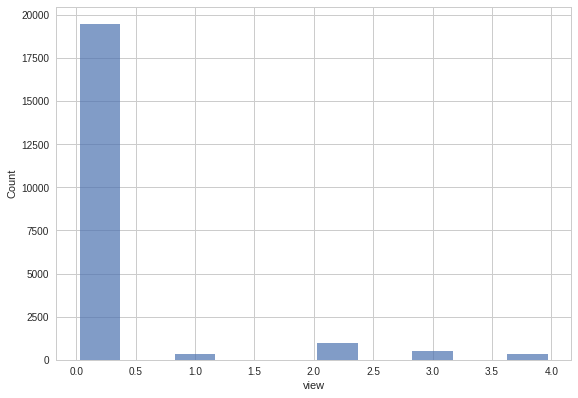

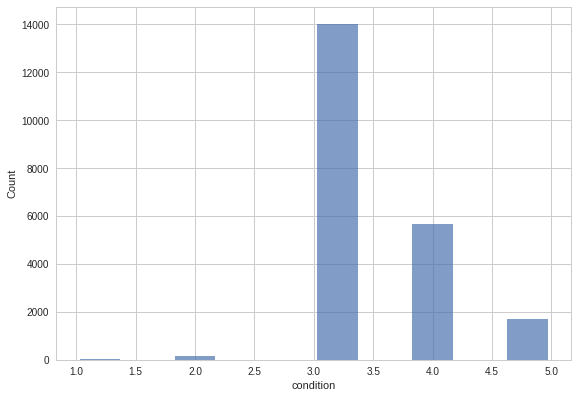

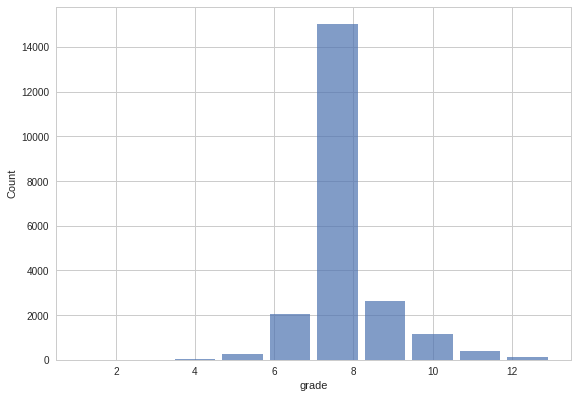

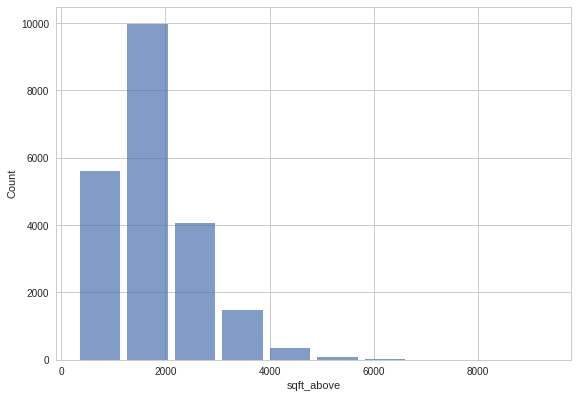

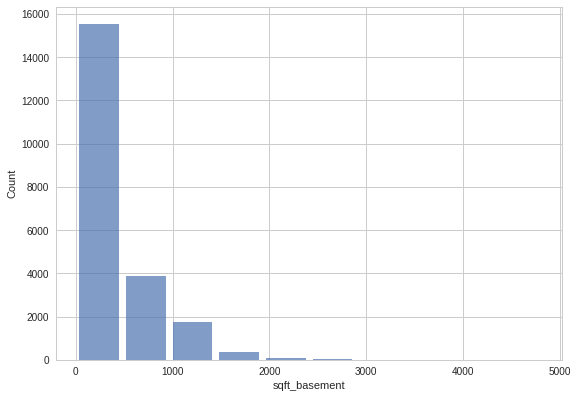

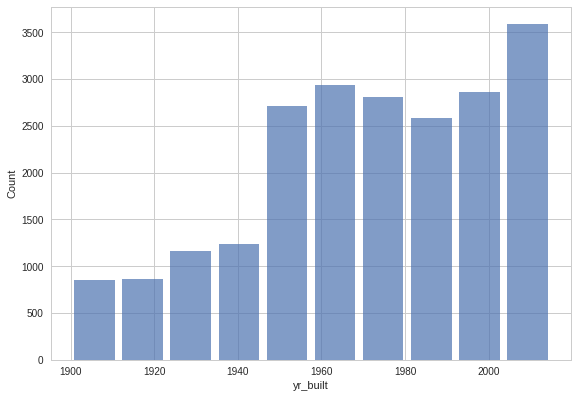

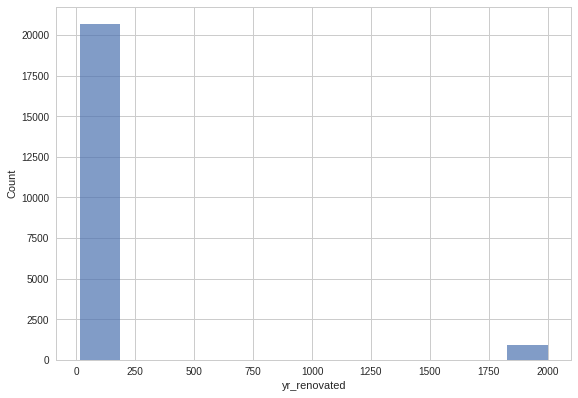

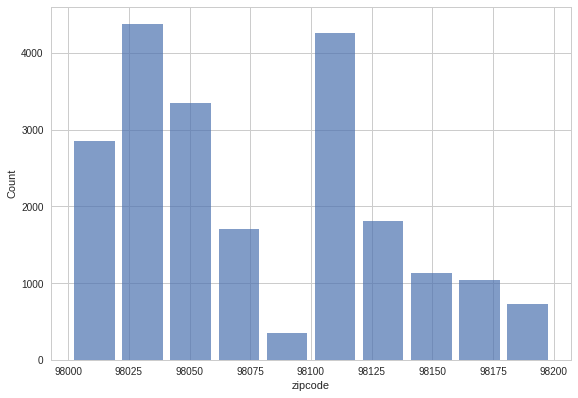

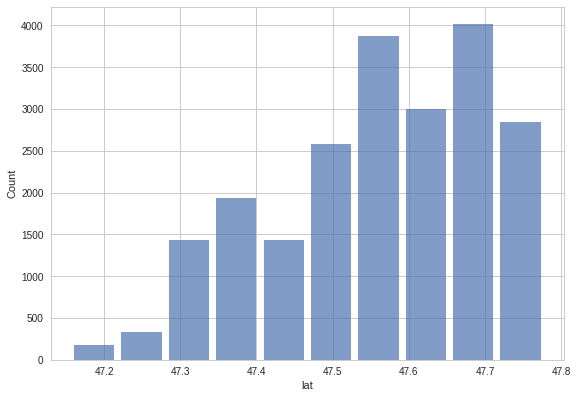

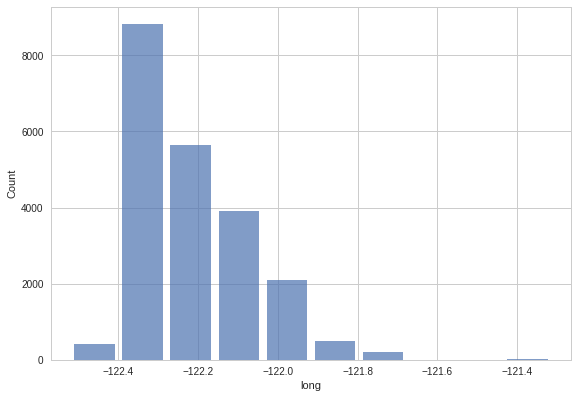

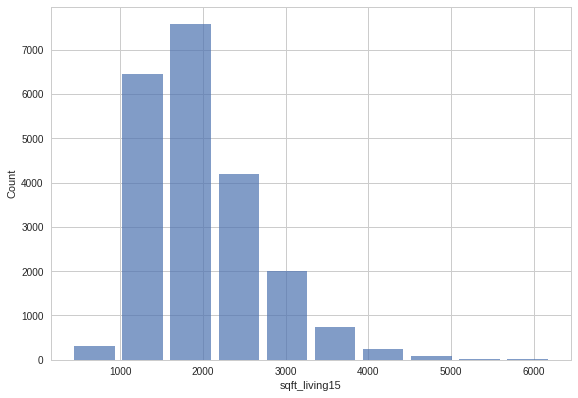

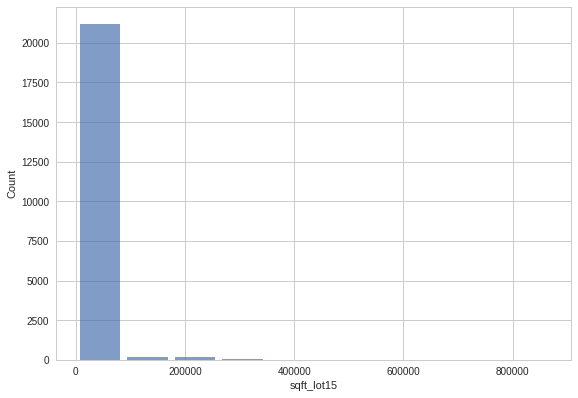

In [13]:
count=0
for i in df:
  if str(i)=='date':
    continue
  plt.figure(count)
  plt.hist(df[i],alpha=0.7, rwidth=0.85)
  plt.tight_layout()
  plt.xlabel(i)
  plt.ylabel('Count')
  count=count+1
plt.show()

In [0]:
#preprocess data
data=pd.read_csv("./drive/My Drive/DataSet/kc_house_data.csv",parse_dates=['date'],dtype = np.float32);
data=data.drop(['id','date'],axis=1)

#One Hot Encoding for yr_renovated
data['yr_renovated'] = data['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)

#remove outlier
housing=data

IQR = housing['price'].quantile(.75) - housing['price'].quantile(.25)
upper_bound = housing['price'].quantile(.75) + 3 * IQR
upper_bound_mask = housing.price > upper_bound

lower_bound = housing['price'].quantile(.25) - 3 * IQR
lower_bound_mask = housing.price < upper_bound
housing_no_outliers = housing[housing["price"] < upper_bound]
housing_no_outliers=housing_no_outliers[housing_no_outliers["price"]> lower_bound]
data=housing_no_outliers

#One Hot Encoding
change2categorical(data,['grade','view','condition','waterfront','floors','yr_renovated'])
data=pd.get_dummies(data)

#normalization by decimal scaling
Dec_scale(data)

X = data.drop('price', axis=1)
y=data["price"].astype('float32')
print(y.head(2))
y=y.values
X=X.astype('float32')

print(X.info())
print(X.head(10))
X=X.values


0    0.02219
1    0.05380
Name: price, dtype: float32
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21193 entries, 0 to 21612
Data columns (total 43 columns):
bedrooms          21193 non-null float32
bathrooms         21193 non-null float32
sqft_living       21193 non-null float32
sqft_lot          21193 non-null float32
sqft_above        21193 non-null float32
sqft_basement     21193 non-null float32
yr_built          21193 non-null float32
zipcode           21193 non-null float32
lat               21193 non-null float32
long              21193 non-null float32
sqft_living15     21193 non-null float32
sqft_lot15        21193 non-null float32
floors_1.0        21193 non-null float32
floors_1.5        21193 non-null float32
floors_2.0        21193 non-null float32
floors_2.5        21193 non-null float32
floors_3.0        21193 non-null float32
floors_3.5        21193 non-null float32
waterfront_0.0    21193 non-null float32
waterfront_1.0    21193 non-null float32
view_0.0         

In [0]:
from sklearn.model_selection import train_test_split

features_train, features_test, targets_train, targets_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train)


featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test) 


train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

train_loader = torch.utils.data.DataLoader(train, batch_size =features_train.shape[0], shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size =features_test.shape[0]  , shuffle = False)


In [0]:
class ANNV2(nn.Module):
  def __init__(self):
    
    super(ANNV2, self).__init__()
    def layerReLU(inp,oup):
      return nn.Sequential(
          nn.Linear(inp,oup),
          nn.BatchNorm1d(oup),
          nn.ReLU(inplace=True),
          #nn.Dropout(0.7)
      )
    self.model = nn.Sequential(
        layerReLU(43,430),
        layerReLU(430,512),
        layerReLU(512,1024),
        layerReLU(1024,2048),
        layerReLU(2048,4096),
        layerReLU(4096,1024),
        layerReLU(1024,512),
        layerReLU(512,256),
        layerReLU(256,128),
    )
    self.fcout=nn.Linear(128,1)
    self.softplus4=nn.Softplus()
  def forward(self,x):
    out=self.model(x)
    out=self.fcout(out)
    
    out=self.softplus4(out)
    return out

Smallest test : 128759.1015625
Smallest train : 125538.90625
Iteration: 50  Loss: 138573.296875  Loss test: 137695.234375 
Smallest test : 116599.5546875
Smallest train : 114928.1484375
Iteration: 100  Loss: 114928.1484375  Loss test: 117287.3671875 
Smallest test : 109234.671875
Smallest train : 108841.8046875
Iteration: 150  Loss: 124710.84375  Loss test: 112233.265625 
Smallest test : 98373.4609375
Smallest train : 97466.5078125
Iteration: 200  Loss: 106149.734375  Loss test: 117841.1796875 
Smallest test : 91996.2109375
Smallest train : 88068.7890625
Iteration: 250  Loss: 88357.7421875  Loss test: 94121.390625 
Smallest test : 86893.46875
Smallest train : 83669.640625
Iteration: 300  Loss: 98177.453125  Loss test: 99576.8359375 
Smallest test : 85374.5
Smallest train : 83669.640625
Iteration: 350  Loss: 97892.9375  Loss test: 95910.609375 
Smallest test : 83729.578125
Smallest train : 78485.703125
Iteration: 400  Loss: 88919.0546875  Loss test: 89682.1171875 
Smallest test : 83092.

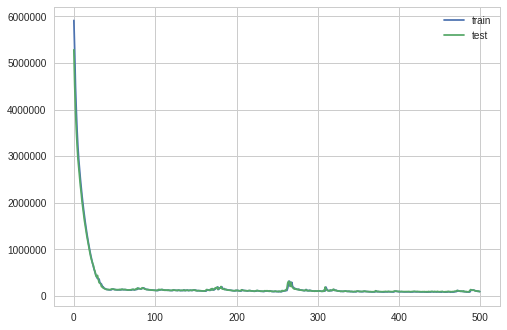

Smallest test : 81587.5234375
Smallest train : 74169.2734375
Iteration: 550  Loss: 74169.2734375  Loss test: 81587.5234375 
Smallest test : 79914.3203125
Smallest train : 72771.953125
Iteration: 600  Loss: 72811.6953125  Loss test: 79914.3203125 
Iteration: 600  Loss: 72811.6953125  Loss test: 79914.3203125 


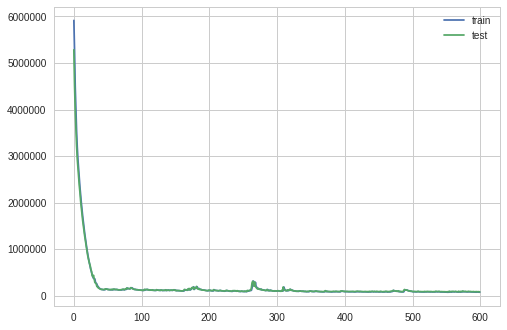

END


In [9]:
model=ANNV2()
model.cuda()
error = nn.L1Loss()
learning_rate =0.0025
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=0.001)
#load_checkpoint("./drive/My Drive/DataSet/ANNV1last.pth.tar", model, optimizer)
#for g in optimizer.param_groups:
#    g['lr'] = 0.001
count = 0
testloss=[]
loss_list = []
testloss_list=[]
iteration_list = []
accuracy_list = []
counts=[]
flag=0
while flag==0 :    
    for trains, labels in train_loader:        
        train = Variable(trains.float()).cuda()
        labels = Variable(labels.float()).view(-1,1).cuda()                
        optimizer.zero_grad()  
        outputs = model(train)
        loss = error(outputs, labels)
        loss.backward()
        optimizer.step()       
        count += 1
        if count % 1 == 0:                      
            for images, labels in test_loader:                
                test = Variable(images.float()).cuda()
                labels = Variable(labels.float()).view(-1,1).cuda()
                outputs = model(test)
                teloss=error(outputs, labels)
            loss_list.append(loss.data[0]*(10**7))           
            testloss_list.append(teloss.data[0]*(10**7))
            counts.append(count)
            iteration_list.append(count)
            if count%50==0:
              print('Smallest test : {}'.format(min(testloss_list)))
              print('Smallest train : {}'.format(min(loss_list)))                
              print('Iteration: {}  Loss: {}  Loss test: {} '.format(count, loss.data[0]*(10**7), teloss.data[0]*(10**7)))                
            if count % 500 == 0:
              plt.plot(range(0,len(loss_list)),loss_list)
              plt.plot(range(0,len(testloss_list)),testloss_list)
              plt.legend(['train','test'])
              plt.show()
              plt.pause(0.0001)
    if teloss.data<0.008:
      print('Iteration: {}  Loss: {}  Loss test: {} '.format(count, loss.data[0]*(10**7), teloss.data[0]*(10**7)))
      break          
plt.plot(range(0,len(loss_list)),loss_list)
plt.plot(range(0,len(testloss_list)),testloss_list)
plt.legend(['train','test'])
plt.show()
print("END")